In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import sys
THRID_PARTY_LIB_PATH = (
    "../../../../SPEER/", # esg_tools
)
for path in THRID_PARTY_LIB_PATH:
    path = os.path.abspath(path)
    if path not in sys.path:
        sys.path.append(path)

# from esg_tools import get_all_entity_strs, get_all_entity_strs, entity_coverage_check, metric_Entity_Recall

In [2]:
TEST_SET='//data/huengchi/Datasets/MEDIQA2021/Task3/dev.json'
MODEL_OUTPUT='../../outputs/RRS_20240408115041_walloper-parablepsy-41'

In [3]:
PREDICTION_SET=os.path.join(MODEL_OUTPUT, 'evals', 'predictions.jsonl')
METRIC_SET=os.path.join(MODEL_OUTPUT, 'evals', 'metric_scores.jsonl')
OUTPUT_DIR=os.path.join(MODEL_OUTPUT, 'evals', 'analysis')
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
test_set = pd.read_json(TEST_SET, lines=True)
pred_set = pd.read_json(PREDICTION_SET, lines=True)
metric_set = pd.read_json(METRIC_SET, lines=True)

test_set = test_set.rename(columns={'example_id': 'id'})

for df in (test_set, pred_set, metric_set):
    print(df.columns)

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999],
      dtype='int64', length=2000)
Index(['id', 'output'], dtype='object')
Index(['id', 'rouge-1%', 'rouge-2%', 'rouge-l%', 'bleu-4', 'bs_f1', 'bs_p'], dtype='object')


In [12]:
np.argmin(metric_set['rouge-l%'])

481

<Axes: ylabel='Frequency'>

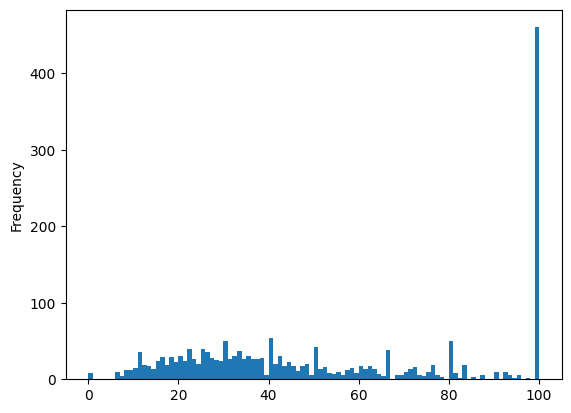

In [8]:
metric_set['rouge-l%'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

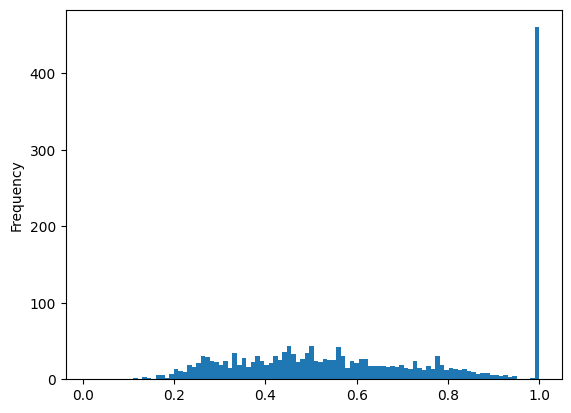

In [9]:
metric_set['bs_f1'].plot.hist(bins=100)